In [3]:
import torch
import torch.nn as nn
import torch.jit

In [ ]:
def node_id(node):
    return node.scopeName() 

In [76]:
def graph_inputs(graph):
    """Returns inputs of graph as list of torch._C.Value"""
    return list(graph.inputs())

def graph_outputs(graph):
    """Returns outputs of graph as list of torch._C.Value"""
    return list(graph.outputs())

def val_size(val):
    return val.type().sizes()

def val_inputs(val):
    return list(val.node().inputs())

def val_outputs(val):
    return list(val.node().outputs())

def val_kind(val):
    return val.node().kind()

def val_is_tensor(val):
    return val.isCompleteTensor()

def val_debug_name(val):
    return val.debugName()

def val_scope_name(val):
    return val.node().scopeName()

def val_tensor(val):
    return val.node().t('value')

In [210]:
class MyModule(nn.Module):
    
    def __init__(self):
        super(MyModule, self).__init__()
        self.a = torch.randn(1, 3, 1, 1)
        
    def forward(self, x, y):
        return x * self.a * y

In [211]:
model = MyModule()

data = torch.zeros((1, 3, 224, 224))

model_jit = torch.jit.trace(model, [data])

graph = model_jit.graph

TypeError: forward() missing 1 required positional argument: 'y'

In [212]:
CONVERTERS = {}


def tensorrt_converter(method):
    def register_converter(converter):
        CONVERTERS[method] = converter
        return converter
    return register_converter


class Context():
    
    def __init__(self, graph, network, converters=CONVERTERS):
        self.graph = graph
        self.network = network
        self.tensors = {}
        self.converters = CONVERTERS

    def get_trt(self, val):
        print('Val %s' % val.debugName())
        if val.debugName() in self.tensors:
            return self.tensors[val.debugName()]  # get tensor directly
        elif val.node().kind() in self.converters:
            print('Calling converter for %s' % val.node().kind())
            self.converters[val.node().kind()](self, val.node())  # attempt recursive conversion
            return self.tensors[val.debugName()]  # tensor should now be set...
        else:
            raise KeyError('No converter found for %s' % val.node().kind())
    
    def set_trt(self, val, val_trt):
        if val.debugName() not in self.tensors:
            self.tensors[val.debugName()] = val_trt
        else:
            raise RuntimeException('TensorRT value already found in graph')

            
def torch2trt(model, data):
    
    model_jit = torch.jit.trace(model, data)
    graph = model_jit.graph
    
    logger = trt.Logger()
    builder = trt.Builder(logger)
    
    ctx = Context(graph, builder.create_network())
    
    for output in graph_outputs(graph):
        
        output_trt = ctx.get_trt(output)
        
        # now, ctx.trt_tensors
        ctx.network.mark_output(output_trt)
    return ctx

In [200]:
def scalar_type_to_trt(dtype):
    if dtype == 'Float':
        return trt.float32
    elif dtype == 'Half':
        return trt.float16
    else:
        raise TypeError('%s is not supported by tensorrt' % dtype)

def torch_dtype_to_trt(dtype):
    if dtype == torch.int8:
        return trt.int8
    elif dtype == torch.int32:
        return trt.int32
    elif dtype == torch.float16:
        return trt.float16
    elif dtype == torch.float32:
        return trt.float32
    else:
        raise TypeError('%s is not supported by tensorrt' % dtype)


def torch_dtype_from_trt(dtype):
    if dtype == trt.int8:
        return torch.int8
    elif dtype == trt.int32:
        return torch.int32
    elif dtype == trt.float16:
        return torch.float16
    elif dtype == trt.float32:
        return torch.float32
    else:
        raise TypeError('%s is not supported by torch' % dtype)

In [214]:
@tensorrt_converter('prim::Constant')
def convert_constant(ctx, node):
    val = next(node.outputs())
    sizes = val.type().sizes()[1:]
    tensor = node.t('value')
    layer = ctx.network.add_constant(tuple(sizes), tensor.cpu().numpy())
    ctx.set_trt(val, layer.get_output(0))

In [215]:
@tensorrt_converter('prim::Param')
def convert_param(ctx, node):
    for val in node.outputs():
        if val.isCompleteTensor():
            sizes = val.type().sizes()
            dtype = val.type().scalarType()
            val_trt = ctx.network.add_input(val.debugName(), scalar_type_to_trt(dtype), tuple(sizes[1:]))
            ctx.set_trt(val, val_trt)

In [216]:
@tensorrt_converter('aten::mul')
def convert_mul(ctx, node):
    inputs_trt = [ctx.get_trt(val) for val in node.inputs()]
    layer = ctx.network.add_elementwise(inputs_trt[0], inputs_trt[1], trt.ElementWiseOperation.PROD)
    ctx.set_trt(next(node.outputs()), layer.get_output(0))

In [217]:
net = torch2trt(model, [data, data])

Val 11
Calling converter for aten::mul
Val 10
Calling converter for aten::mul
Val x
Calling converter for prim::Param
Val 9
Calling converter for prim::Constant
Val y


In [218]:
from torch2trt.utils import trt_network_to_dot_graph

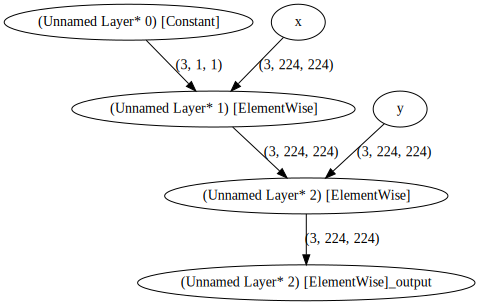

In [219]:
trt_network_to_dot_graph(net.network)

In [190]:
graph

graph(%self : ClassType<MyModule>,
      %x : Float(1, 3, 224, 224)):
  %2 : Float(1, 3, 1, 1) = prim::Constant[value=(1,1,.,.) =   -1.1048  (1,2,.,.) =    0.4352  (1,3,.,.) =    0.5167 [ Variable[CPUFloatType]{1,3,1,1} ]](), scope: MyModule # <ipython-input-104-0e0d3c77cb20>:8:0
  %3 : Float(1, 3, 224, 224) = aten::mul(%x, %2), scope: MyModule # <ipython-input-104-0e0d3c77cb20>:8:0
  return (%3)

In [166]:
t = val.type()

In [170]:
va.

'Float'

In [168]:
n = val.node()

In [172]:
n.attributeNames()

[]

In [169]:
val.type.

<bound method PyCapsule.type of x defined in (%self : ClassType<MyModule>, %x : Float(1, 3, 224, 224) = prim::Param()
)>

In [140]:
import pdb
pdb.pm()

> <ipython-input-106-23400b74a02b>(24)get_trt()
-> return self.tensors[val.debugName()]  # tensor should now be set...


(Pdb)  print self.tensors


*** SyntaxError: Missing parentheses in call to 'print'. Did you mean print(self.tensors)?


(Pdb)  p self.tensors


{}


(Pdb)  q


In [135]:
graph

graph(%self : ClassType<MyModule>,
      %x : Float(1, 3, 224, 224)):
  %2 : Float(1, 3, 1, 1) = prim::Constant[value=(1,1,.,.) =   -1.1048  (1,2,.,.) =    0.4352  (1,3,.,.) =    0.5167 [ Variable[CPUFloatType]{1,3,1,1} ]](), scope: MyModule # <ipython-input-104-0e0d3c77cb20>:8:0
  %3 : Float(1, 3, 224, 224) = aten::mul(%x, %2), scope: MyModule # <ipython-input-104-0e0d3c77cb20>:8:0
  return (%3)

In [159]:
queue = []
call_trace = []

queue += graph_outputs(graph)

while queue:
    val = queue.pop(0)
    queue += val_inputs(val)
    print(val)
    
    if val_kind(val) == 'prim::Constant':
        break

11 defined in (%11 : Float(1, 3, 224, 224) = aten::mul(%9, %10), scope: MyModule # <ipython-input-78-2efbdc103968>:8:0
)
9 defined in (%9 : Float(1, 3, 224, 224) = aten::mul(%x, %8), scope: MyModule # <ipython-input-78-2efbdc103968>:8:0
)
10 defined in (%10 : Float(1, 3, 1, 1) = prim::Constant[value=(1,1,.,.) =   -0.5971  (1,2,.,.) =    0.3635  (1,3,.,.) =    0.4893 [ Variable[CPUFloatType]{1,3,1,1} ]](), scope: MyModule # <ipython-input-78-2efbdc103968>:8:0
)
